# Requirements

In [4]:
data = '/content/drive/MyDrive/Major Project/data/'

In [5]:
! pip install pmdarima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dateutil.parser import parse
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from datetime import timedelta
from pmdarima.arima import auto_arima
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import PolynomialFeatures
pd.set_option('mode.use_inf_as_na',True)
def getModel( y , X = None, verbose = True):
    model = pm.auto_arima( X = X, y = y , start_p=1, start_q=1, test='adf', m=1, d=None, max_d = 10, seasonal=False, trace = verbose, suppress_warnings=True, stepwise=True, maxiter = 100)
    return model
def forecast(model, X = None, period = 60, field = 'Daily Confirmed'):
    fc, confint = model.predict( X = X, n_periods=period , return_conf_int=True)
    fc_series = pd.Series(fc)
    return fc_series

     |████████████████████████████████| 1.5MB 15.2MB/s 
     |████████████████████████████████| 9.5MB 22.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Extracting CSV

In [6]:
cleaned =  pd.read_csv(os.path.join(data, 'central_data/cleaned.csv'), parse_dates=[0])
# cleaned.drop(columns=['public_information_campaigns', 'testing_policy', 'vaccination_policy', 'total_vaccinations', 'Total Confirmed', 'Daily Recovered','Total Recovered', 'Total Deceased','close_public_transport',
      #  'cancel_public_events','facial_coverings','people_vaccinated', 'people_fully_vaccinated', 'stay_home_requirements', 'residential','Daily Deceased'], inplace=True)
cleaned = cleaned[['Day','Daily Confirmed']]
# cleaned['percentage_change'] = cleaned['Daily Confirmed'].pct_change()
# cleaned['mobility_driving'].ffill(inplace=True)
# cleaned['mobility_walking'].ffill(inplace=True)

# Functions to get regression model

In [7]:
def get_lagged(df=cleaned,n=14):
  # lag_variables  = ['Daily Confirmed','stringency_index', 'mobility_driving','mobility_walking', 'retail_and_recreation', 'grocery_and_pharmacy', 'transit_stations', 'parks', 'workplaces', 'stringency_index']
  lag_variables  = ['Daily Confirmed']
  lags = range(1,n+1)
  for lag in lags:
    new_df = df.copy()
    new_df.Day += timedelta(lag)
    new_df = new_df[['Day']+lag_variables]
    new_df.columns = ['Day']+ [lag_feat +'_lag_'+str(lag) for lag_feat in lag_variables]
    df = pd.merge( df, new_df, on=['Day'], how='left')
    del new_df

  df.fillna(0, inplace=True)
  cols = df.columns
  for col in cols:
    if col in lag_variables:
      df.drop(columns=col, inplace=True)
  return df

def tester(clean, n):
  # clean2 = clean.copy()
  final = get_lagged(clean,n)
  # final = clean.copy()
  # for cols in clean.columns[2:-1]:
  #   clean2[cols] = clean2[cols] - 0.75*(abs(clean2[cols]))
  # clean2['stringency_index'] = 1.5*clean2['stringency_index']
  # final2 = get_lagged(clean2,n)
  # final2 = clean2.copy()
  X_train = final.drop(final.tail(56).index)
  # X_train = final
  X_test1 = final.tail(56)
  # X_test2 = final2.tail(56)
  X_train.drop(columns=['Day'], inplace=True)
  # X_train.drop(columns=['Day', 'Daily Confirmed'], inplace=True)
  X_test1.drop(columns=['Day'], inplace=True)
  # X_test1.drop(columns=['Day','Daily Confirmed'], inplace=True)
  # X_test2.drop(columns=['Day'], inplace=True)
  # X_test2.drop(columns=['Day','Daily Confirmed'], inplace=True)
  y_train = cleaned['Daily Confirmed'].head(-56)
  # y_train = cleaned['Daily Confirmed']
  y_test = cleaned['Daily Confirmed'].tail(56)
  linreg = LinearRegression().fit(X_train, y_train)
  print('linear model coeff (w): {}'.format(linreg.coef_))
  print('rmse score (training): {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train)))))
  print('R-squared score (training): {:.3f}'.format(linreg.score(X_train, y_train)))
  print('rmse score (test): {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, linreg.predict(X_test1)))))
  print('R-squared score (test): {:.3f}'.format(linreg.score(X_test1, y_test)))
  print('mae score (test): {:.3f}'.format(metrics.mean_absolute_error(y_test,linreg.predict(X_test1))))
  # y_pred = linreg.predict(X_test1)
  plt.figure(figsize=(20, 10))
  plt.plot(final['Day'].head(-56), y_train, label = 'First Wave')
  plt.plot(cleaned['Day'].head(-56),linreg.predict(X_train), label='predicted First Wave')
  plt.plot(final['Day'].tail(56),y_test, label= 'Second Wave')
  plt.plot(cleaned['Day'].tail(56),linreg.predict(X_test1), color='red', label='predicted Second Wave')
  # plt.plot(cleaned['Day'].tail(56),linreg.predict(X_test2), color='green', label='predicted Second Wave with 75% less mobility')
  plt.legend()
  plt.show()
  # print('rmse score: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(linreg.predict(X_test2), linreg.predict(X_test1)))))
  return linreg,linreg.predict(X_test1)

# Numeric value entered can be changed to use lag of those days

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


linear model coeff (w): [ 0.66657957  0.17226914  0.13370923 -0.04487483 -0.00970898  0.09657733
  0.72750583 -0.46852902 -0.24035381 -0.03899454]
rmse score (training): 2203.292
R-squared score (training): 0.994
rmse score (test): 5678.579
R-squared score (test): 0.983
mae score (test): 3585.179


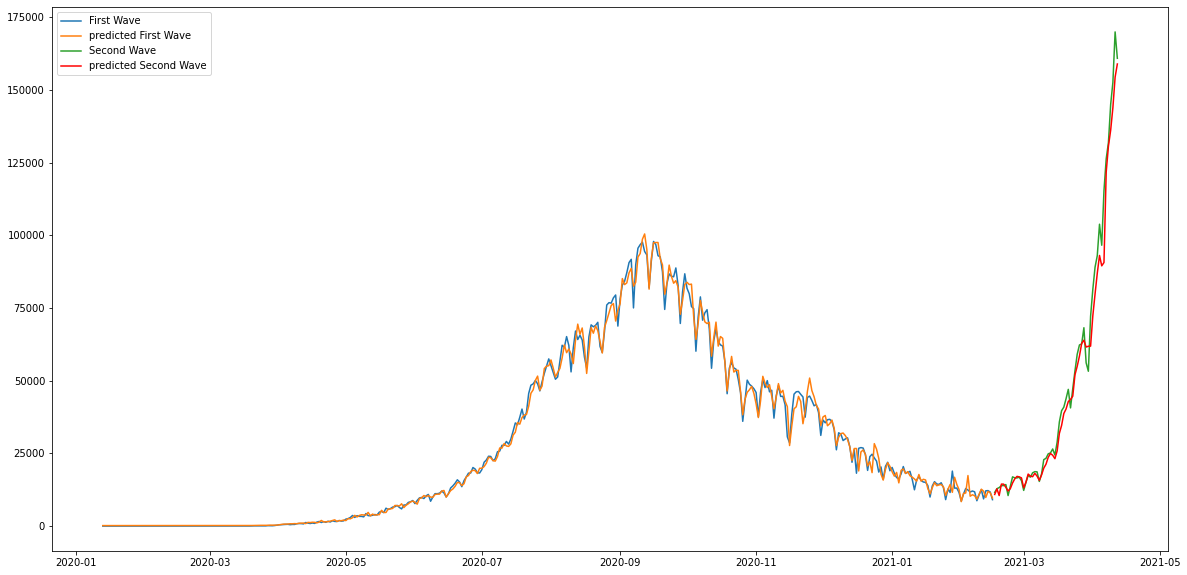

In [16]:
linreg, y_pred = tester(cleaned,10)

# Forecasting functions, use linreg model and ypreds from previous cell ouput

In [17]:
# m=number of days
# n=lag of n days
# linreg and y_pred used from previous cells
def forecast_Mdays(m,n,linreg,y_pred):
  cleaned2 = cleaned.copy()
  for i in range(m):
    tp = get_lagged(cleaned2,n)
    y = linreg.predict(tp.iloc[:,1:].tail(1))[0]
    cleaned2.loc[len(cleaned2.index)] = [cleaned2.loc[len(cleaned2.index)-1,'Day']+timedelta(days=1),y]
    # for col in cleaned.columns[1:-1]:
    #   cleaned2[col].ffill(inplace=True)
    # cleaned2.fillna(0,inplace=True)
    # cleaned2.loc[400+i,'Daily Confirmed'] = y
    del tp

  plt.figure(figsize=(20, 10))
  # plt.plot(cleaned['Day'].head(400), cleaned['Daily Confirmed'].head(400), label = 'First Wave')
  plt.plot(cleaned['Day'].tail(57),cleaned['Daily Confirmed'].tail(57), color='green', label= 'Second Wave')
  plt.plot(cleaned['Day'].tail(56),y_pred,label='predicted Second Wave')
  plt.plot(cleaned2['Day'].tail(m+1),cleaned2['Daily Confirmed'].tail(m+1), color='red', label='forecasted for next {} days'.format(m))
  plt.legend()
  plt.show()

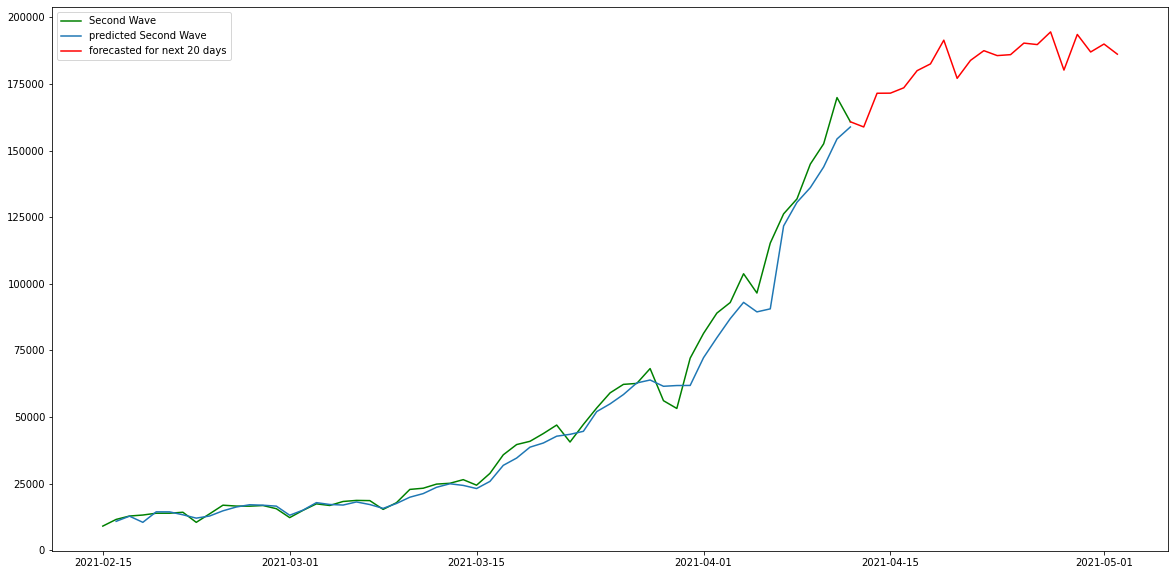

In [18]:
forecast_Mdays(20,10,linreg,y_pred)

# ARIMA Model

In [11]:
 def arima_tester(clean,n):
  clean2 = clean.copy()
  final = get_lagged(clean,n)
  # final = clean.copy()
  # for cols in clean.columns[2:-1]:
  #   clean2[cols] = clean2[cols] - 0.75*(abs(clean2[cols]))
  # clean2['stringency_index'] = 1.5*clean2['stringency_index']
  # final2 = get_lagged(clean2,n)
  # final2 = clean2.copy()
  X_train = final.drop(final.tail(56).index)
  # X_train = final
  X_test1 = final.tail(56)
  # X_test2 = final2.tail(56)
  X_train.drop(columns=['Day'], inplace=True)
  # X_train.drop(columns=['Day', 'Daily Confirmed'], inplace=True)
  X_test1.drop(columns=['Day'], inplace=True)
  # X_test1.drop(columns=['Day','Daily Confirmed'], inplace=True)
  # X_test2.drop(columns=['Day'], inplace=True)
  # X_test2.drop(columns=['Day','Daily Confirmed'], inplace=True)
  y_train = cleaned['Daily Confirmed'].head(-56)
  # y_train = cleaned['Daily Confirmed']
  y_test = cleaned['Daily Confirmed'].tail(56)
  model = getModel(y_train,X_train)
  ypred1 = forecast(model,X_test1,56,'Daily Confirmed')
  # ypred2 = forecast(model,X_test2,56,'Daily Confirmed')
  plt.figure(figsize=(20, 5))
  plt.plot(final['Day'].head(-56), y_train, label = 'First Wave')
  plt.plot(final['Day'].tail(56),y_test, label= 'Second Wave')
  plt.plot(final['Day'].tail(56),ypred1, color='red', label='predicted Second Wave')
  # plt.plot(final['Day'].tail(56),ypred2, color='green', label='predicted Second Wave with 75% less mobility')
  plt.legend()
  plt.show()
  print('rmse score (test): {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test,ypred1))))
  # print('R-squared score (test): {:.3f}'.format(linreg.score(X_test1, y_test)))
  print('mae score (test): {:.3f}'.format(metrics.mean_absolute_error(y_test,ypred1)))
  return ypred1

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7320.620, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9314.187, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7318.602, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7318.621, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7320.595, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7322.612, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7319.321, Time=0.59 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.586 seconds


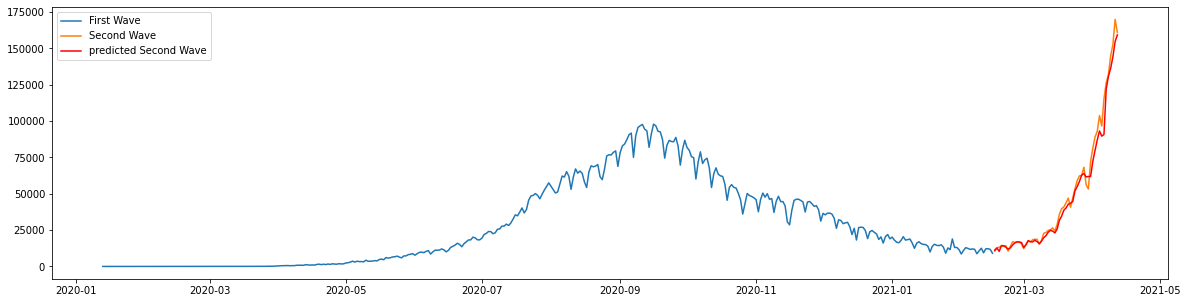

rmse score (test): 5640.820
mae score (test): 3574.264


0      10732.900185
1      12672.412043
2      10359.811628
3      14305.866834
4      14291.738778
5      13187.919678
6      11941.332631
7      12730.519108
8      14682.670654
9      16125.643049
10     16974.125245
11     16795.087022
12     16447.936003
13     13033.751820
14     14953.462477
15     17761.969936
16     17066.599895
17     16859.696175
18     18029.170979
19     17058.400451
20     15616.506189
21     17457.597136
22     19806.183445
23     21171.274443
24     23541.646798
25     24865.301654
26     24251.537764
27     23083.132766
28     25764.976487
29     31801.325786
30     34543.348085
31     38647.796439
32     40210.517595
33     42779.039177
34     43493.352757
35     44610.348813
36     52019.993715
37     54933.479708
38     58444.303791
39     62812.003590
40     63915.910201
41     61578.618868
42     61845.300145
43     61857.456020
44     72312.802790
45     79856.677219
46     87018.913663
47     93147.480295
48     89608.123375
49     90755.947956


In [12]:
arima_tester(cleaned,10)